# F1 - Train Machine Learning Models
Develop a machine learning model to predict if an F1 driver will be on the podium, in the points, or not in the points.

Model registry logic follows the guide from Snowflake here:<br>
https://github.com/Snowflake-Labs/sfguide-intro-to-machine-learning-with-snowpark-ml-for-python/blob/main/3_snowpark_ml_model_training_inference.ipynb

### Steps
1. Read in the data from the `fct_results` table in Snowflake (built by dbt). 
2. Preprocess the data using a pipeline already saved in a Snowflake Stage.
3. Split the data into training and test sets.
4. Develop and train the machine learning models using the training set.
5. Evaluate the models using the test data.
6. Save the models to the Snowflake Stage so it can be called by a downstream dbt Python model.

### Imports

In [32]:
import os
import warnings
from pprint import pprint

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
# import snowflake.ml.modeling.preprocessing as snowml
from dotenv import load_dotenv
from snowflake.ml.modeling.metrics import accuracy_score
from snowflake.ml.modeling.model_selection.grid_search_cv import GridSearchCV
# from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.registry import registry
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
# from snowflake.snowpark import types as T
from snowflake.snowpark.version import VERSION as SNOWPARK_VERSION

warnings.simplefilter("ignore")

#### Constants

In [2]:
# Get environment variables from .env file. This file is not committed to git.
# It should contain the following variables:
#   SNOWFLAKE_ACCOUNT=<account_name>
#   SNOWFLAKE_ML_USER=<username>
#   SNOWFLAKE_ML_PASSWORD=<password>

load_dotenv()  # Get environment variables from .env file

# Connection
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")  # From .env file
DATABASE = "FORMULA1"
WAREHOUSE = "TRANSFORMING"
ROLE = "TRANSFORMER"
DEV_SCHEMA = "DBT_GREG"  # Replace with dev schema storing feature data
USER = os.getenv("SNOWFLAKE_ML_USER")  # From .env file
PASSWORD = os.getenv("SNOWFLAKE_ML_PASSWORD")  # From .env file


# Snowflake Stage and Pipeline file
ML_SCHEMA = "ML"
ML_STAGE = "F1_STAGE"
PIPELINE_FILE = "f1_preprocess_pipeline.joblib"

# Features
TARGET = ["POSITION_LABEL"]  # 1 = podium, 2 = points, 3 = no points
ORIGINAL_FEATURES = [
    "RACE_YEAR",
    "CIRCUIT_NAME",
    "GRID",
    "CONSTRUCTOR_NAME",
    "DRIVER",
    "DRIVERS_AGE_YEARS",
    "DRIVER_CONFIDENCE",
    "CONSTRUCTOR_RELIABILITY",
    "TOTAL_PIT_STOPS_PER_RACE",
]

### Get Data from Snowflake

In [3]:
# Create a Snowflake session
session = Session.builder.configs(
    {
        "account": ACCOUNT,
        "database": DATABASE,
        "warehouse": WAREHOUSE,
        "role": ROLE,
        "schema": DEV_SCHEMA,
        "user": USER,  #
        "password": PASSWORD,
    }
).create()
session.sql_simplifier_enabled = True
snowflake_env = session.sql("select current_user(), current_version()").collect()

pprint("Connected to Snowflake with the following parameters:")
pprint(f"User: {snowflake_env[0][0]}")
pprint(f"Role: {session.get_current_role()}")
pprint(f"Database: {session.get_current_database()}")
pprint(f"Warehouse: {session.get_current_warehouse()}")
pprint(f"Schema: {session.get_current_schema()}")
pprint(f"Snowflake version: {snowflake_env[0][1]}")
pprint(
    f"Snowpark for Python version: {SNOWPARK_VERSION[0]}.{SNOWPARK_VERSION[1]}.{SNOWPARK_VERSION[2]}"
)

'Connected to Snowflake with the following parameters:'
'User: GREG_CLUNIES'
'Role: "TRANSFORMER"'
'Database: "FORMULA1"'
'Warehouse: "TRANSFORMING"'
'Schema: "DBT_GREG"'
'Snowflake version: 8.8.2'
'Snowpark for Python version: 1.11.1'


In [4]:
table_df = session.table("F1_FEATURES")
features_df = table_df.select(TARGET + ORIGINAL_FEATURES)
features_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"POSITION_LABEL"  |"RACE_YEAR"  |"CIRCUIT_NAME"         |"GRID"  |"CONSTRUCTOR_NAME"  |"DRIVER"          |"DRIVERS_AGE_YEARS"  |"DRIVER_CONFIDENCE"  |"CONSTRUCTOR_RELIABILITY"  |"TOTAL_PIT_STOPS_PER_RACE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0                 |2010         |BAHRAIN_GRAND_PRIX     |4       |MCLAREN             |LEWIS_HAMILTON    |25                   |0.911215             |0.855491                   |0                           |
|1                 |2010         |BAHRAIN_GRAND_PRIX     |1       |RED_BULL            |SEBASTIAN_VETTEL  |23                   |0.902326             |0.847025     

In [5]:
features_df.group_by("CIRCUIT_NAME").count().show(50)

-----------------------------------------
|"CIRCUIT_NAME"               |"COUNT"  |
-----------------------------------------
|BAHRAIN_GRAND_PRIX           |83       |
|AUSTRALIAN_GRAND_PRIX        |66       |
|MALAYSIAN_GRAND_PRIX         |39       |
|CHINESE_GRAND_PRIX           |65       |
|SPANISH_GRAND_PRIX           |85       |
|MONACO_GRAND_PRIX            |65       |
|TURKISH_GRAND_PRIX           |24       |
|GERMAN_GRAND_PRIX            |50       |
|HUNGARIAN_GRAND_PRIX         |85       |
|BELGIAN_GRAND_PRIX           |85       |
|ITALIAN_GRAND_PRIX           |85       |
|SINGAPORE_GRAND_PRIX         |65       |
|JAPANESE_GRAND_PRIX          |65       |
|RUSSIAN_GRAND_PRIX           |75       |
|MEXICAN_GRAND_PRIX           |50       |
|AZERBAIJAN_GRAND_PRIX        |35       |
|FRENCH_GRAND_PRIX            |26       |
|STYRIAN_GRAND_PRIX           |20       |
|TUSCAN_GRAND_PRIX            |20       |
|PORTUGUESE_GRAND_PRIX        |20       |
|BRAZILIAN_GRAND_PRIX         |66 

### Preprocess the Data
Preprocess the data using the pipeline loaded from the Snowflake Stage. This performs:
- Normalization of numerical features
- One hot encoding of categorical features

In [6]:
# Get and load the preprocessing pipeline
session.file.get(f"@{ML_SCHEMA}.{ML_STAGE}/{PIPELINE_FILE}.gz", ".")
preprocess_pipeline = joblib.load(f"{PIPELINE_FILE}.gz")

In [7]:
processed_df = preprocess_pipeline.fit(features_df).transform(features_df)
processed_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Drop the original features, keeping the preprocessed features.

In [8]:
data_df = processed_df.drop(ORIGINAL_FEATURES)  # Keep normalized and encoded features
data_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Split Data into Training and Test Sets

In [9]:
# Data is fairly small, so test split is 40% to get a race from all circuits
train_df, test_df = data_df.random_split([0.6, 0.4], seed=0)

### Build a ML model using Snowpark
We will build a classification model to predict if an F1 driver will be on the podium, in the points, or not in the points.

We'll use the Snowpark `XGBClassifier` and `GridSearchCV` to build and tune the model. Both are optimized for Snowflake.

#### Hyperparameter Tuning

In [10]:
TARGET = ["POSITION_LABEL"]
FEATURES = [col for col in data_df.columns if col not in TARGET]
PREDICTION_COL = ["PREDICTED_POSITION_LABEL"]

# Tune an XGB Classifier model using sklearn GridSearchCV.
grid_search_cv = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        "n_estimators": [50, 100, 200, 300, 400, 500],
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs=-1,  # Use all available cores
    scoring="accuracy",
    input_cols=FEATURES,
    label_cols=TARGET,
    output_cols=PREDICTION_COL,
)

grid_search_cv.fit(train_df)

#### Explore best model
We can use `to_sklearn()` to get the XGBoost model object with all its attributes and methods.

In [11]:
grid_search_cv.to_sklearn().best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

We can also analyze the grid search results to understand the best hyperparameters.

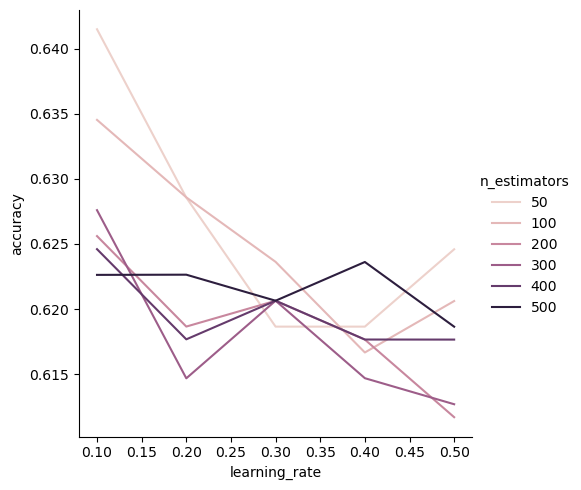

In [18]:
gs_results = grid_search_cv.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []

for params in gs_results["params"]:
    n_estimators_val.append(params["n_estimators"])
    learning_rate_val.append(params["learning_rate"])

accuracy = gs_results["mean_test_score"]
accuracy
gs_result_df = pd.DataFrame(
    data={
        "n_estimators": n_estimators_val,
        "learning_rate": learning_rate_val,
        "accuracy": accuracy,
    },
)

sns.relplot(
    data=gs_result_df, x="learning_rate", y="accuracy", hue="n_estimators", kind="line"
)

Could the model be imporved? Almost certainly.

For the sake of this demo, register the model in Snowflake so it can be called by a downstream dbt Python model.

### Making Predictions

In [16]:
# Predict on test data
result = grid_search_cv.predict(test_df)

# Analyze the results
accuracy = accuracy_score(
    df=result, y_true_col_names=TARGET[0], y_pred_col_names=PREDICTION_COL[0]
)
result.select(TARGET[0], PREDICTION_COL[0]).show()
print(f"Accuracy Score: {accuracy}")

-------------------------------------------------
|"POSITION_LABEL"  |"PREDICTED_POSITION_LABEL"  |
-------------------------------------------------
|0                 |0.0                         |
|1                 |1.0                         |
|2                 |2.0                         |
|1                 |1.0                         |
|2                 |1.0                         |
|0                 |0.0                         |
|1                 |1.0                         |
|1                 |1.0                         |
|1                 |1.0                         |
|1                 |2.0                         |
-------------------------------------------------

Accuracy Score: 0.696594


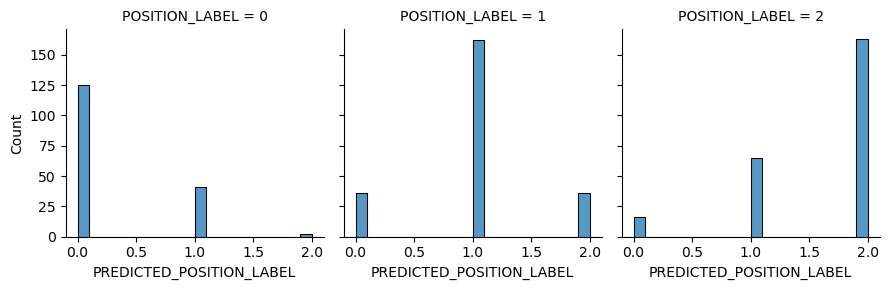

In [19]:
# # Plot actual vs predicted
g = sns.FacetGrid(result.toPandas(), col="POSITION_LABEL", col_wrap=3)
g.map(sns.histplot, PREDICTION_COL[0], bins=20)

### Deploy Model using Model Registry

### Model Metadata
Get optimal model and its metadata.

In [21]:
optimal_model = grid_search_cv.to_sklearn().best_estimator_
optimal_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [20]:
optimal_n_estimators = grid_search_cv.to_sklearn().best_params_["n_estimators"]
optimal_learning_rate = grid_search_cv.to_sklearn().best_params_["learning_rate"]

optimal_accuracy = gs_result_df.loc[
    (gs_result_df["n_estimators"] == optimal_n_estimators)
    & (gs_result_df["learning_rate"] == optimal_learning_rate),
    "accuracy",
].values[0]
pprint(f"Optimal n_estimators: {optimal_n_estimators}")
pprint(f"Optimal learning_rate: {optimal_learning_rate}")
pprint(f"Optimal accuracy: {optimal_accuracy}")

'Optimal n_estimators: 50'
'Optimal learning_rate: 0.1'
'Optimal accuracy: 0.6414807152357026'


### Log Model to Registry

In [22]:
# Define model name
MODEL_NAME = "F1_XGB_MODEL"

In [23]:
# Create a model registry
native_registry = registry.Registry(
    session=session,
    database_name=DATABASE,
    schema_name=ML_SCHEMA,
    # create_if_not_exists=True,
)

In [24]:
# Get sample input data to pass into the registry logging function
X = train_df.select(FEATURES)

# Log model to registry
model_ver = native_registry.log_model(
    model_name=MODEL_NAME,
    version_name="V0",
    model=optimal_model,
    sample_input_data=X,  # To provide the feature schema
)

model_ver.set_metric(metric_name="accuracy", value=optimal_accuracy)
model_ver.comment = "XGBoost model for predicting F1 driver position"

Add metric metadata and comment to the model in the Model Registry.

In [27]:
model_ver2 = native_registry.log_model(  # This is a dummy model version just to show registry capabilities
    model_name=MODEL_NAME,
    version_name="V1",
    model=optimal_model,
    sample_input_data=X,  # To provide the feature schema
)

model_ver2.set_metric(metric_name="accuracy", value=optimal_accuracy)
model_ver2.comment = "XGBoost model for predicting F1 driver position"

In [28]:
native_registry.get_model(MODEL_NAME).show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-02-26 20:57:07.935000-08:00,V0,XGBoost model for predicting F1 driver position,FORMULA1,ML,F1_XGB_MODEL,true,"[""PREDICT_PROBA"",""PREDICT"",""APPLY""]","{""metrics"": {""accuracy"": 0.6414807152357026}, ...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."
1,2024-02-26 21:01:18.215000-08:00,V1,XGBoost model for predicting F1 driver position,FORMULA1,ML,F1_XGB_MODEL,false,"[""PREDICT_PROBA"",""PREDICT"",""APPLY""]","{""metrics"": {""accuracy"": 0.6414807152357026}, ...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."


Every model has a default version. Let's get it.

In [30]:
native_registry.get_model(MODEL_NAME).default.version_name

'V0'

### Call Model From Registry to Make Predictions

In [41]:
model_ver = native_registry.get_model(MODEL_NAME).version("v1")
predict_df = model_ver.run(test_df, function_name="predict")  # Make predictions using the test data

In [42]:
# Renam the prediction column to something more meaningful
final_df = predict_df.rename(F.col('"output_feature_0"'), "PREDICTED_POSITION_LABEL")
final_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### OPTIONAL - Cleanup

In [ ]:
# BE CAREFUL RUNNING THIS CELL
# native_registry.delete_model(model_name)  # Uncomment to run and delete the model

In [ ]:
# Confirm it was deleted
native_registry.show_models()